# Comparing different datasets, sample level, NK cells

- CLR normalized ADT counts are for each marker in each sample are visualized
- Different Neurips sites (analyzing laboratories) are compared
- Also cell numbers of different samples are visualized

### NK cell markers collected from following references:
- Mustjoki group (R-code + other information)
- Pfefferle, A. et al.  (2019). A Temporal Transcriptional Map of Human Natural Killer Cell Differentiation. BioRxiv, 630657. https://doi.org/10.1101/630657
- Melsen, J. et al. (2022). Single-cell transcriptomics in bone marrow delineates CD56dimGranzymeK+ subset as intermediate stage in NK cell differentiation. Frontiers in immunology, 13, 1044398. https://doi.org/10.3389/fimmu.2022.1044398
- Yang, C. et al.(2019). Heterogeneity of human bone marrow and blood natural killer cells defined by single-cell transcriptome. Nature communications, 10(1), 3931. https://doi.org/10.1038/s41467-019-11947-7

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## File preparations

### Neurips

In [2]:
#Neurips

adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm.h5ad')

In [3]:
adata_neurips.obs['new_cell_type'].unique()

['NK', 'T', 'Prog', 'Myel', 'B', 'DC', 'E', 'Normoblast']
Categories (8, object): ['B', 'DC', 'E', 'Myel', 'NK', 'Normoblast', 'Prog', 'T']

In [4]:
#Select only NK cells

neurips_nk=adata_neurips[adata_neurips.obs['new_cell_type'] == 'NK' ]

In [5]:
neurips_nk

View of AnnData object with n_obs × n_vars = 7388 × 8051
    obs: 'cell_type', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'eg_code', 'leiden_r1', 'new_cell_type', 'batch_group'
    uns: 'neighbors', 'new_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    obsp: 'connectivities', 'distances'

In [6]:
neurips_nk_prot=neurips_nk.obsm['protein_expression_clr_neurips']

In [7]:
#To exclude columns that contain only zeros

neurips_nk_prot = pd.DataFrame(neurips_nk_prot)
neurips_nk_prot != 0
(neurips_nk_prot != 0).any(axis=0)
neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]
neurips_nk_prot = neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]


In [8]:
nk_all = ['CD5',
 'CD52',
 'CD160',
 'CD226',
 'CD56',
 'CD2',
 'CD27',
 'CD158b',
 'CD127',
 'CD122',
 'CD38',
 'CD34',
 'CD161',
 'CD314',
 'TIGIT',
 'CD57',
 'CD195',
 'CD155',
 'CD335',
 'CD44',
 'CD7',
 'CD69',
 'CD94',
 'CD16',
 'CD62L']

In [9]:
#Used to check which markers were used in Neurips

listOfmarkers= nk_all

nk_all= []

for x in listOfmarkers:
    if x in neurips_nk_prot.columns:
        print(x, "Yes")
        nk_all.append(x)
    else:
        print(x, "No") 

CD5 Yes
CD52 Yes
CD160 No
CD226 Yes
CD56 Yes
CD2 Yes
CD27 Yes
CD158b Yes
CD127 Yes
CD122 Yes
CD38 Yes
CD34 No
CD161 Yes
CD314 Yes
TIGIT Yes
CD57 Yes
CD195 Yes
CD155 Yes
CD335 Yes
CD44 Yes
CD7 Yes
CD69 Yes
CD94 Yes
CD16 Yes
CD62L Yes


### Neurips

In [10]:
samples=adata_neurips.obs['POOL'].unique().tolist()

In [11]:
#save means of protein counts/each protein/each sample into a list

list_samples= []

for sample in samples:
    eg=adata_neurips[adata_neurips.obs['new_cell_type'] == 'NK']
    eg=adata_neurips[adata_neurips.obs['POOL'] == sample]
    prot=eg.obsm['protein_expression_clr_neurips']
    prot_mean=prot.mean(axis=0).sort_values()
    list_samples.append(prot_mean)

    

In [12]:
#Count total cell numbers + NK cell numbers

all_cells_neurips=[]
nk_cell_neurips=[]

for sample in samples:
    all_cells_neurips.append(len(adata_neurips[adata_neurips.obs['POOL'] == sample]))
    nk_cell_neurips.append(len(neurips_nk[neurips_nk.obs['POOL'] == sample]))

print(all_cells_neurips)
print(nk_cell_neurips)
    

[4885, 10316, 4450, 9684, 10802, 4575, 4123, 6565, 3535, 8725, 8478, 4860]
[665, 846, 518, 529, 1198, 151, 202, 730, 262, 1814, 210, 263]


In [16]:
#save column names
proteins=adata_neurips.obsm['protein_expression_clr_neurips'].columns

In [17]:
#creating a dataframe from list of lists

df = pd.DataFrame(list_samples, columns = proteins)


In [18]:
df=df.T

In [19]:
#add column names

df.columns=samples


In [20]:
df=df.T

In [21]:
#remove columns that contain only zeros

df = pd.DataFrame(df)
df != 0
(df != 0).any(axis=0)
df.loc[:, (df != 0).any(axis=0)]
df = df.loc[:, (df != 0).any(axis=0)]

In [22]:
index_sort = df.mean().sort_values().index
df_sorted = df[index_sort]

In [23]:
df_sorted=df_sorted.T

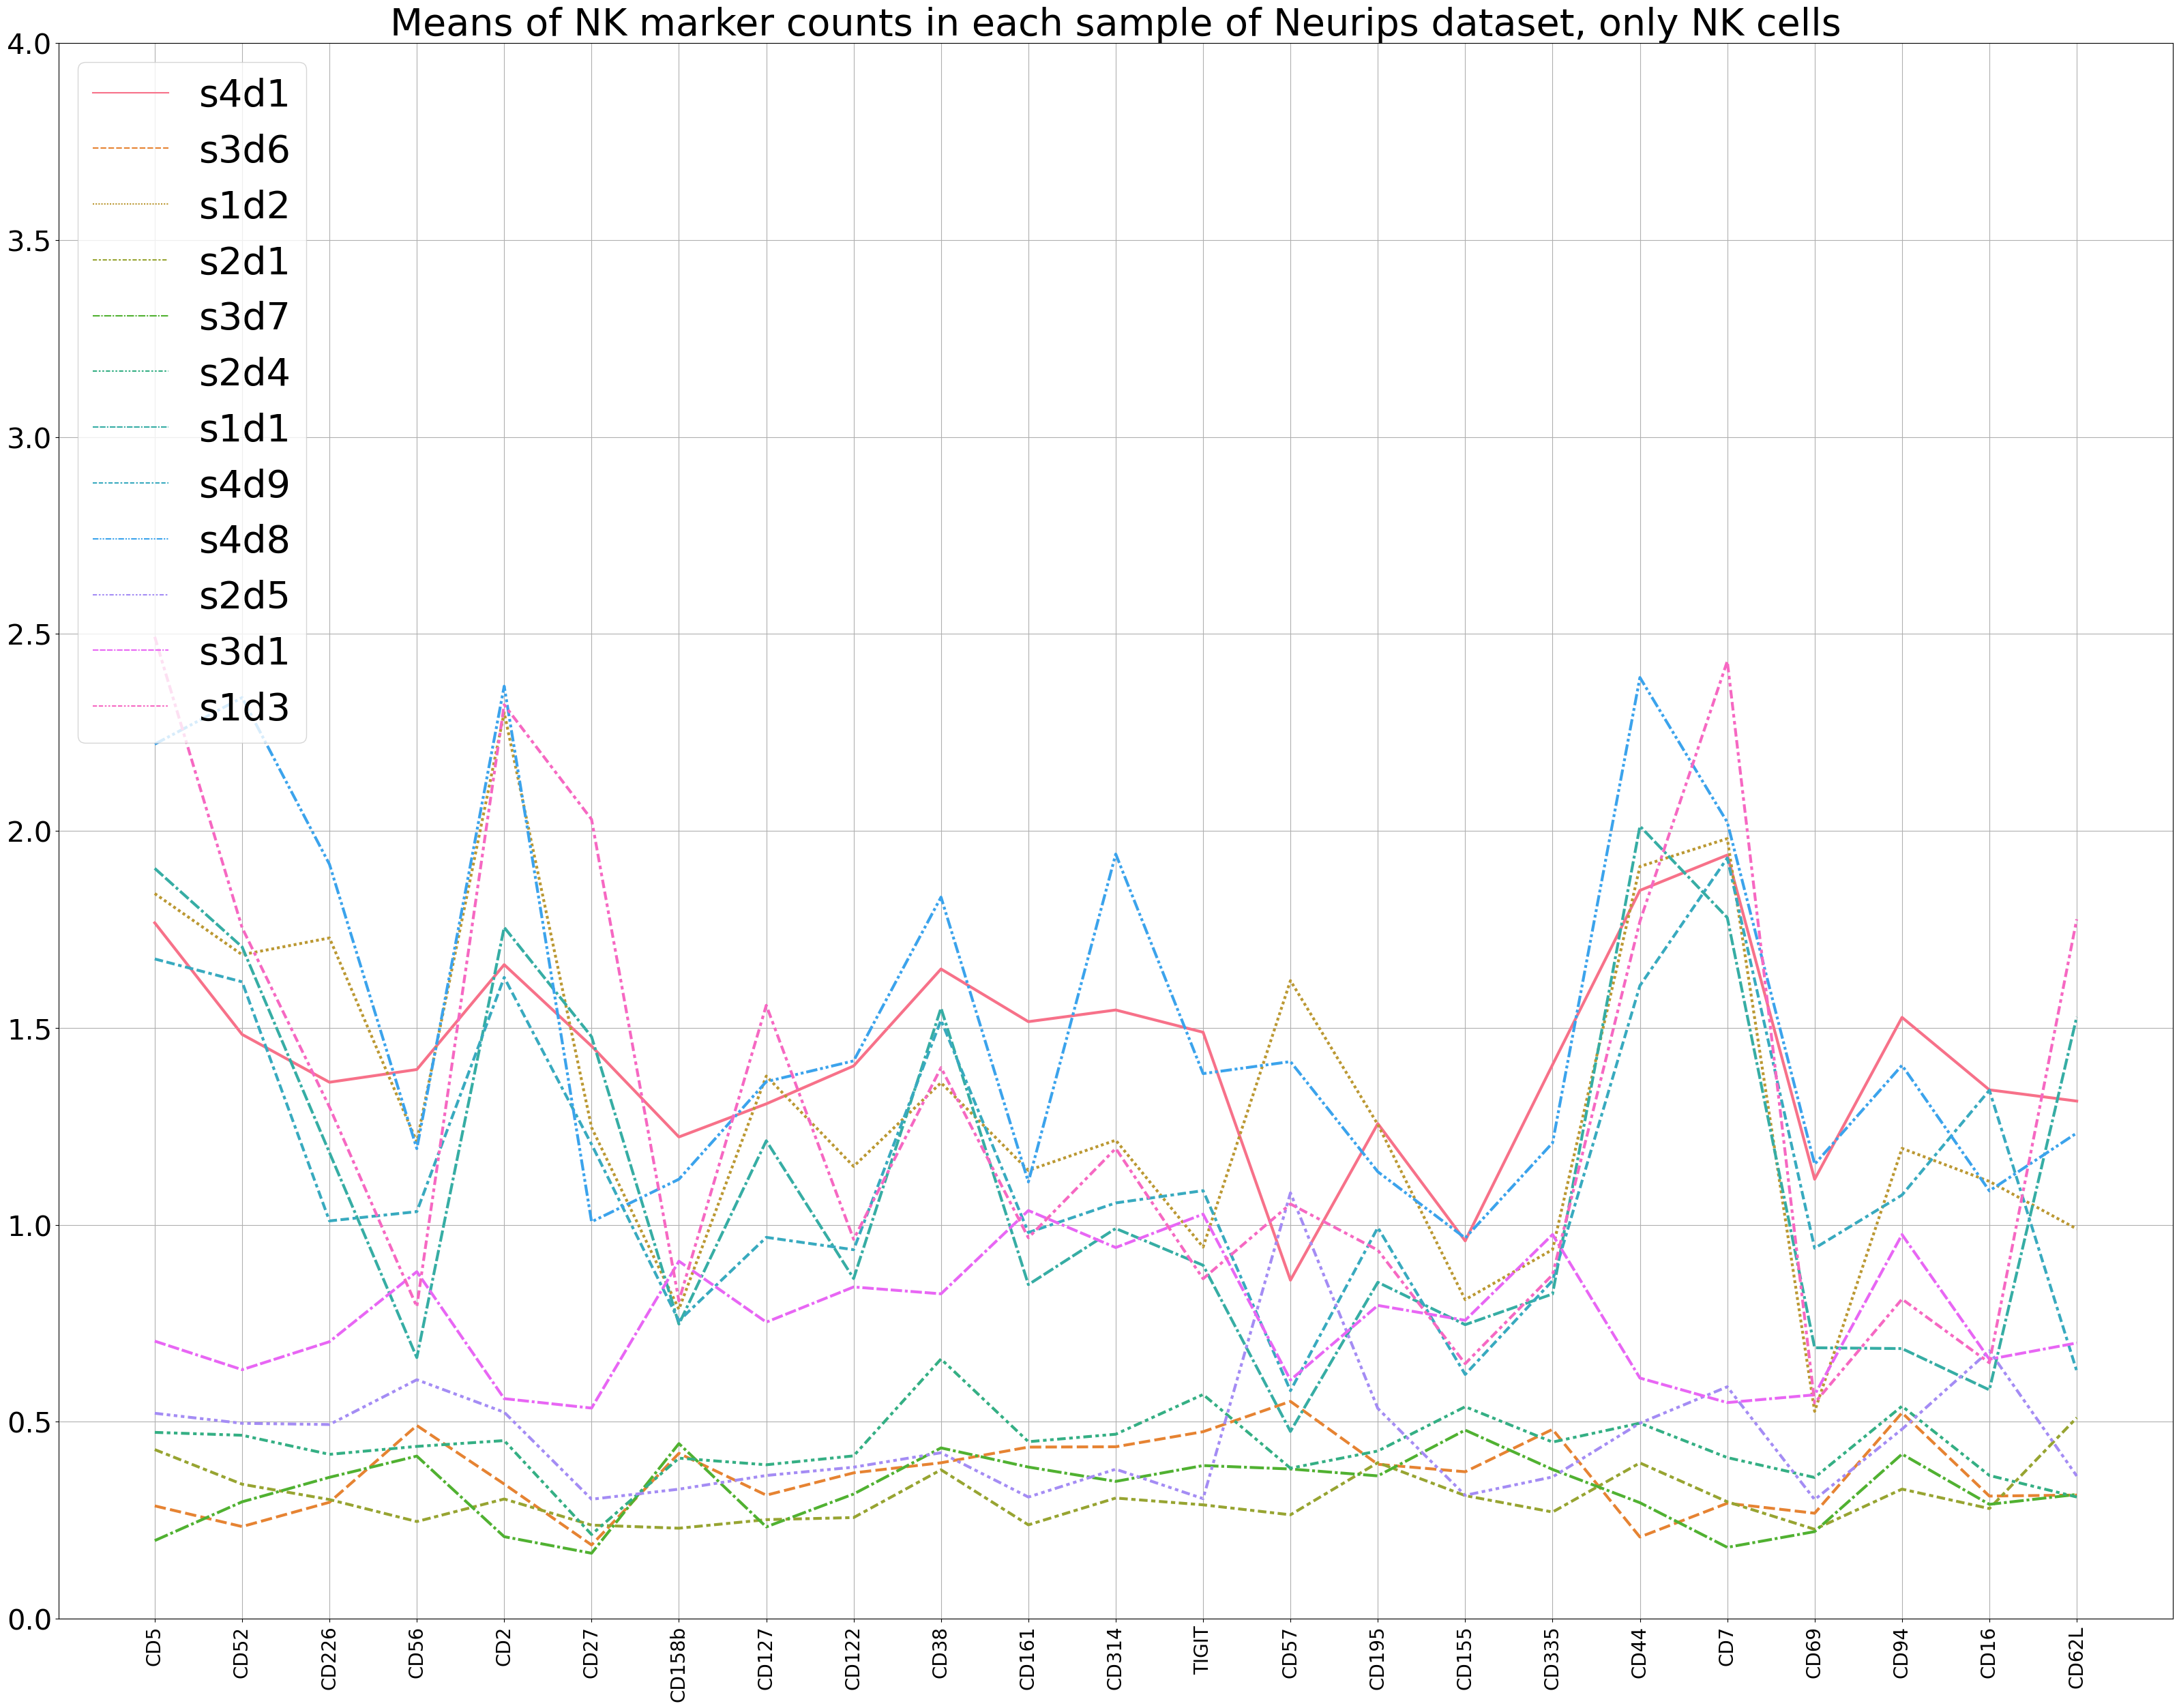

In [24]:
#only NK cells selected from each sample, CLR normalized

palette = sns.color_palette("husl", 12)


plt.figure(figsize=[40,30])
a= sns.lineplot(data=df_sorted.loc[nk_all], palette=palette, linewidth = 3)
a.set_xticklabels(a.get_xticklabels(),rotation=90) 
a.tick_params(axis='x', labelsize=20)
a.tick_params(axis='y', labelsize=30)
plt.ylim(0, 4)
plt.legend(loc='upper left', fontsize = 40, facecolor='white')
plt.grid()
plt.title("Means of NK marker counts in each sample of Neurips dataset, only NK cells", fontsize=40) ;




In [25]:
df_sorted.T

,TCRVd2,CD194,TCRVa7.2,CD42b,CD158e1,CD25,CD1c,CD146,CD103,IgD,...,CD47,HLA-A-B-C,CD44,CD81,CD11a,CD45RA,CD7,CD2,CD45,CD5
s4d1,0.665076,0.958827,0.905964,1.043606,1.091735,1.080279,0.905249,1.049192,1.065979,0.930738,...,1.610546,1.760489,1.848751,1.838738,1.896102,1.483842,1.938531,1.660241,1.684020,1.766428
s3d6,0.158318,0.218237,0.238211,0.295162,0.302102,0.254409,0.218034,0.302837,0.325588,0.120745,...,0.200408,0.228202,0.207254,0.297849,0.288648,0.424696,0.293036,0.341791,0.229554,0.286301
s1d2,0.316631,0.575823,0.445114,0.529079,0.512646,0.595072,0.564102,0.612642,0.648368,0.511047,...,1.822831,1.627263,1.909522,1.787953,2.057640,2.242679,1.980217,2.300188,2.063965,1.840709
s2d1,0.073591,0.268547,0.119025,0.219541,0.182849,0.255392,0.206386,0.186954,0.200278,0.271968,...,0.412130,0.346285,0.395398,0.250911,0.362868,0.396372,0.296759,0.303741,0.374771,0.429235
s3d7,0.137893,0.193026,0.206742,0.272644,0.234811,0.203448,0.226082,0.256404,0.286846,0.122100,...,0.250612,0.293415,0.294397,0.244202,0.399151,0.392966,0.181030,0.208118,0.282711,0.198172
s2d4,0.194087,0.404011,0.214715,0.301287,0.315190,0.280196,0.302109,0.291323,0.333655,0.346982,...,0.539152,0.474773,0.496273,0.458739,0.498955,0.502431,0.408966,0.452069,0.511406,0.472912
s1d1,0.304384,0.672118,0.429427,0.565049,0.497007,0.722347,0.819291,0.625665,0.687057,1.066962,...,1.986176,1.906951,2.011889,1.655031,1.873453,1.820197,1.779618,1.754938,2.035544,1.904649
s4d9,0.323518,0.434092,0.574719,0.498799,0.655788,0.611487,0.668388,0.559020,0.600221,1.148763,...,1.483739,1.671932,1.606962,1.891398,1.387226,1.545636,1.931010,1.627833,1.663338,1.674751
s4d8,0.483149,0.711207,1.562635,0.768313,0.830868,0.803593,0.853610,0.930567,0.928822,1.031492,...,2.338416,2.599331,2.389188,2.770256,2.530337,1.872543,2.021836,2.367131,2.514055,2.219946
s2d5,0.083282,0.304008,0.124636,0.325668,0.347092,0.172981,0.185343,0.184192,0.196218,0.095083,...,0.519450,0.463481,0.496405,0.366651,0.575098,0.595833,0.588660,0.524069,0.576690,0.521419


In [26]:
#saving NK markers from all samples into a list

list_samples=[]

for sample in samples:
    eg=adata_neurips[adata_neurips.obs['new_cell_type'] == 'NK']
    eg=adata_neurips[adata_neurips.obs['POOL'] == sample]
    prot=eg.obsm['protein_expression_clr_neurips']
    prot_marker=prot[nk_all]
    list_samples.append(prot_marker)

In [27]:
#NK markers saved for each sample

s4d1= list_samples[0]
s3d6= list_samples[1]
s1d2= list_samples[2]
s2d1= list_samples[3]
s3d7= list_samples[4]
s2d4= list_samples[5]
s1d1= list_samples[6]
s4d9= list_samples[7]
s4d8= list_samples[8]
s2d5= list_samples[9]
s3d1= list_samples[10]
s1d3= list_samples[11]


In [28]:
s4d1["Sample"] = "s4d1"
s3d6["Sample"] = "s3d6"
s1d2["Sample"] = "s1d2"
s2d1["Sample"] = "s2d1"
s3d7["Sample"] = "s3d7"
s2d4["Sample"] = "s2d4"
s1d1["Sample"] = "s1d1"
s4d9["Sample"] = "s4d9"
s4d8["Sample"] = "s4d8"
s2d5["Sample"] = "s2d5"
s3d1["Sample"] = "s3d1"
s1d3["Sample"] = "s1d3"

In [29]:
df_all=pd.concat([s4d1,s3d6,s1d2,s2d1,s3d7,s2d4,s1d1,s4d9,s4d8,s2d5,s3d1,s1d3])


In [30]:
df_all = df_all.T.drop_duplicates().T

In [31]:
df_all.columns

Index(['CD5', 'CD52', 'CD226', 'CD56', 'CD2', 'CD27', 'CD158b', 'CD127',
       'CD122', 'CD38', 'CD161', 'CD314', 'TIGIT', 'CD57', 'CD195', 'CD155',
       'CD335', 'CD44', 'CD7', 'CD69', 'CD94', 'CD16', 'CD62L', 'Sample'],
      dtype='object')

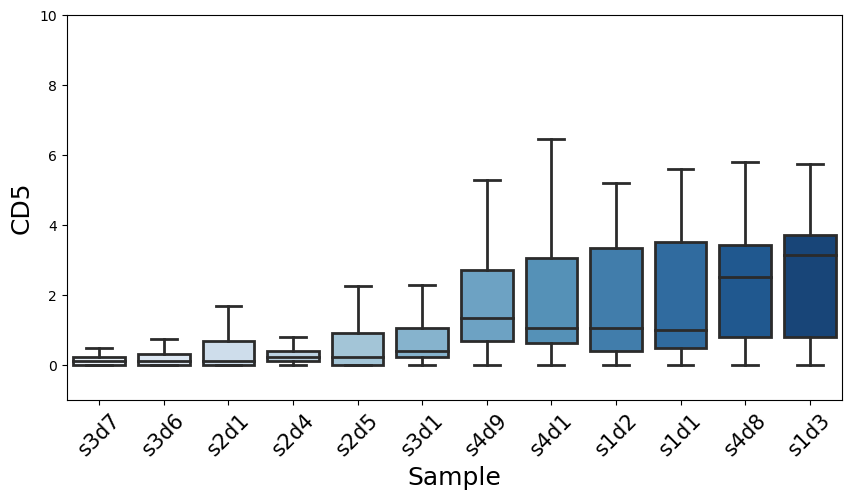

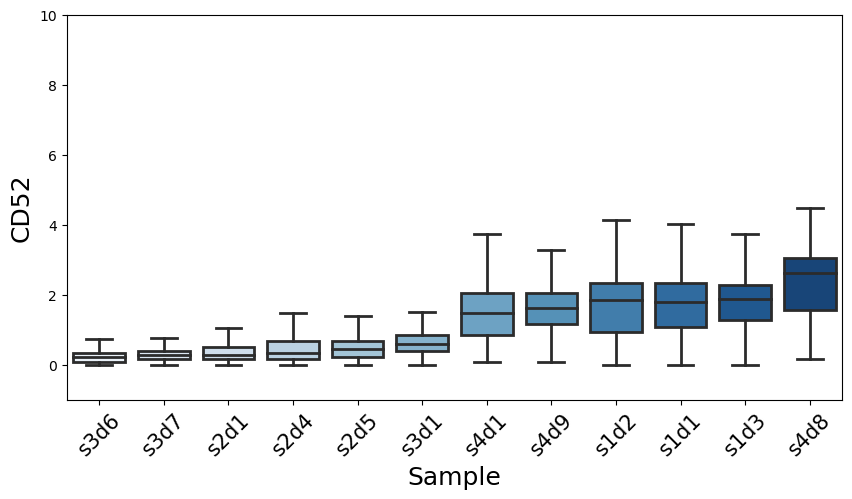

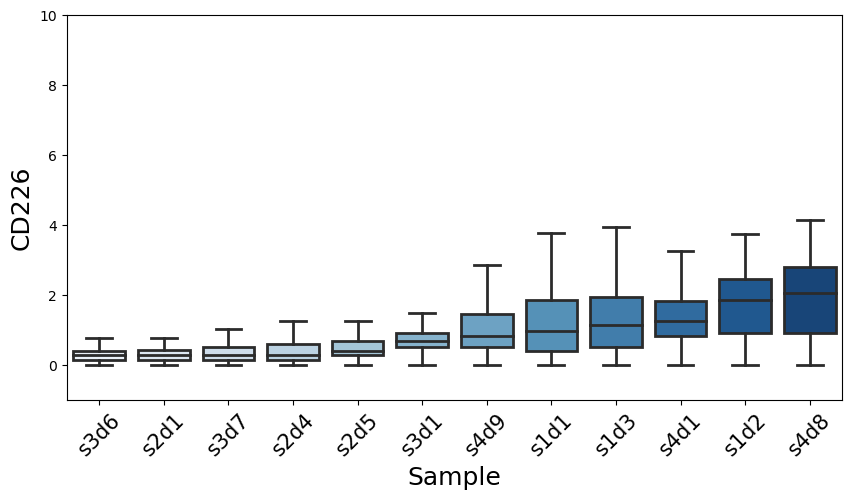

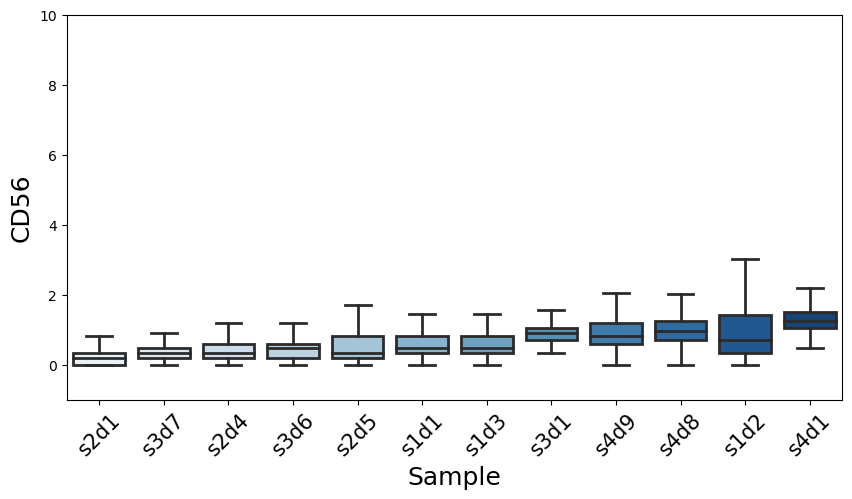

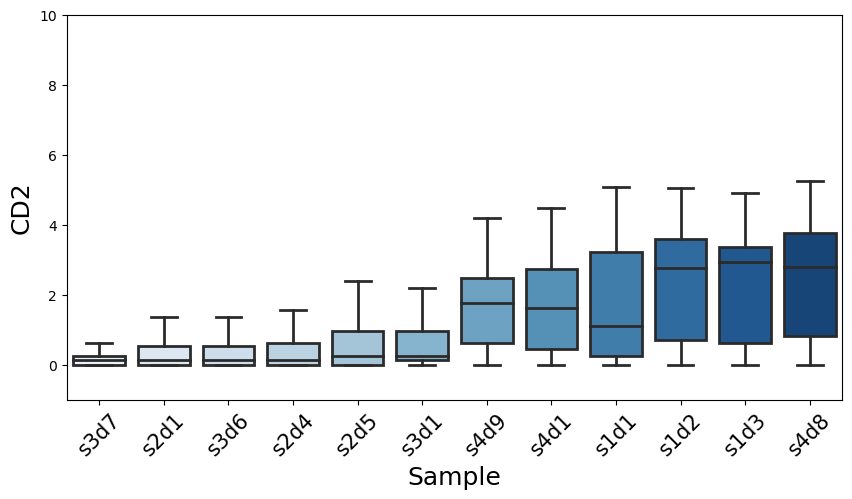

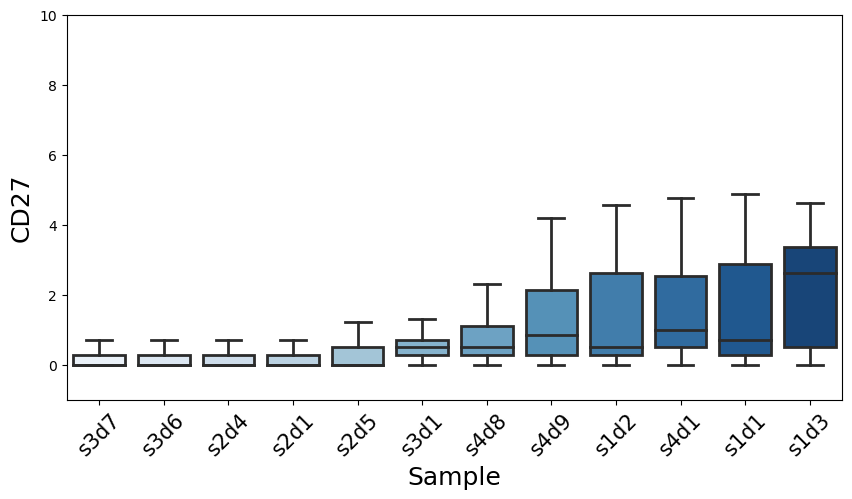

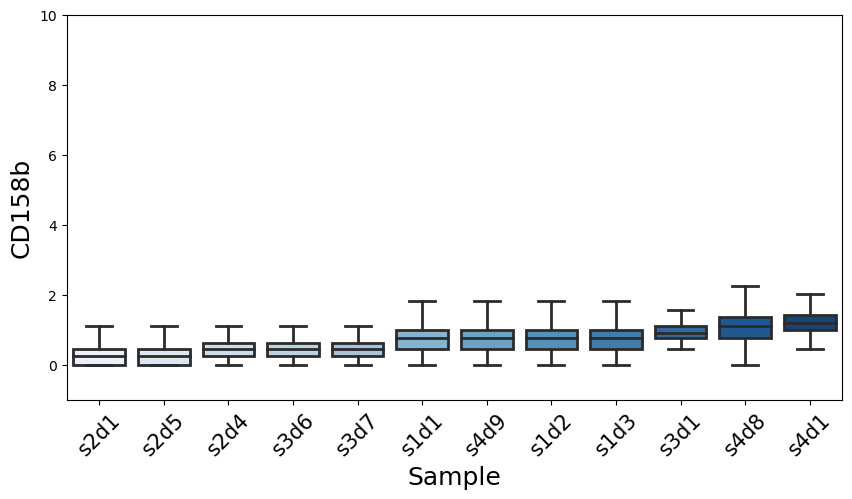

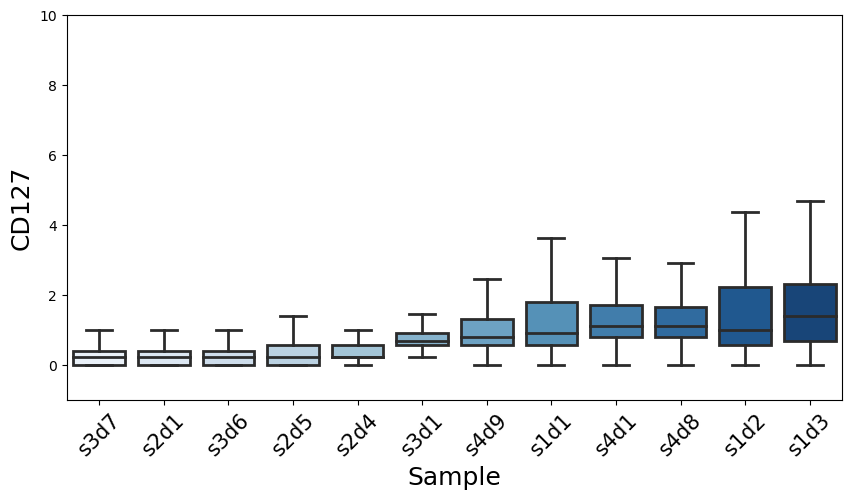

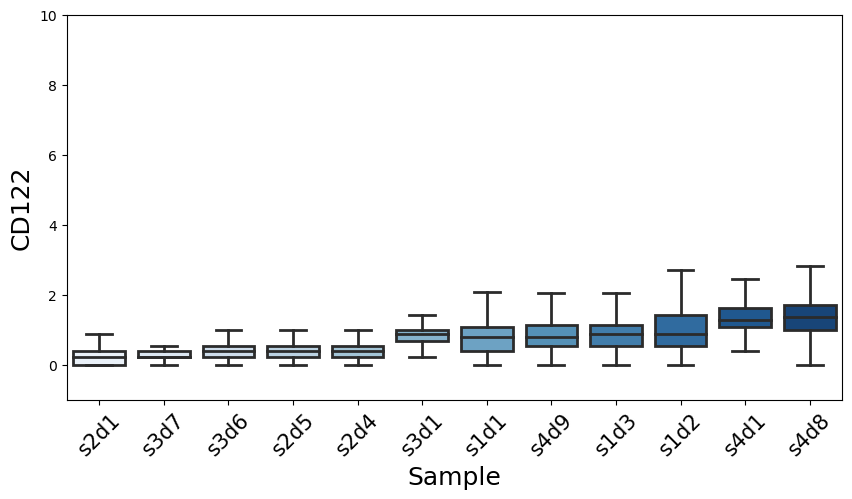

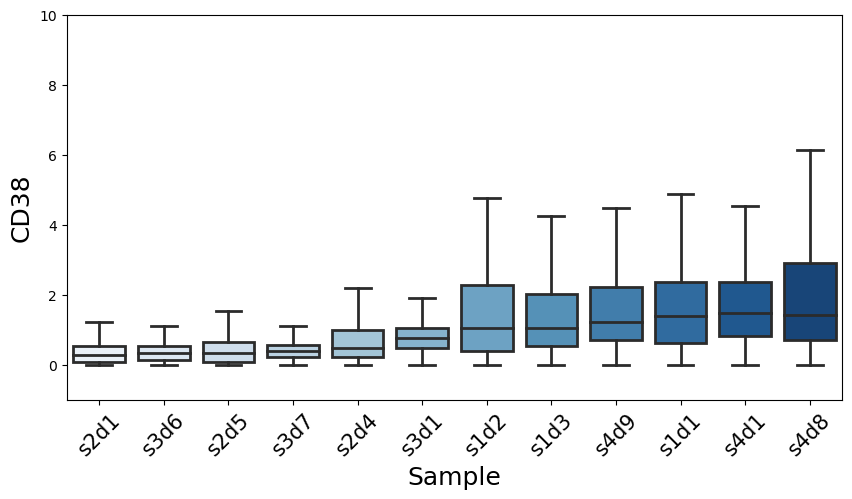

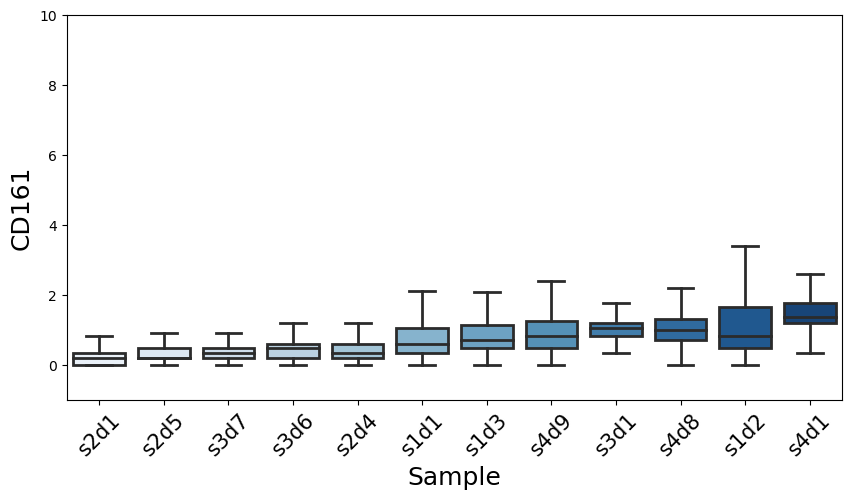

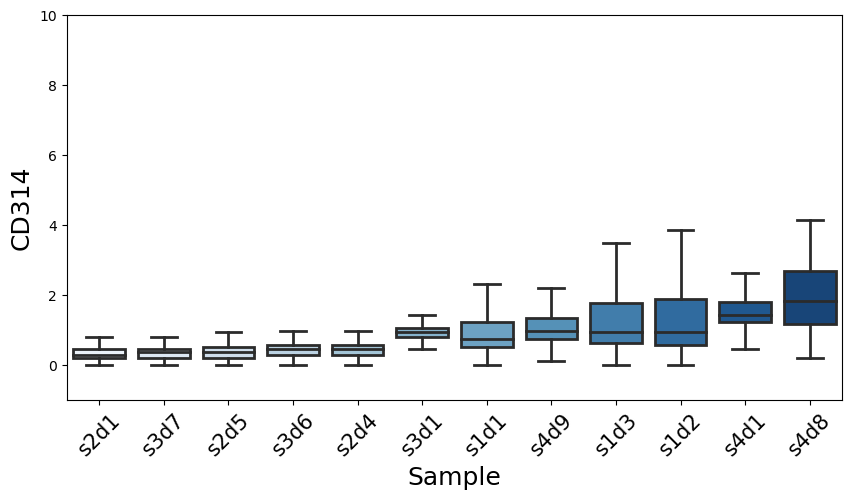

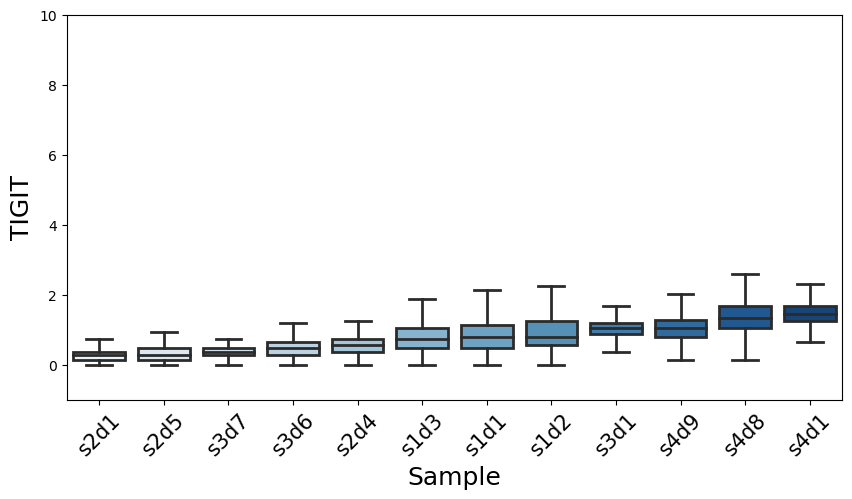

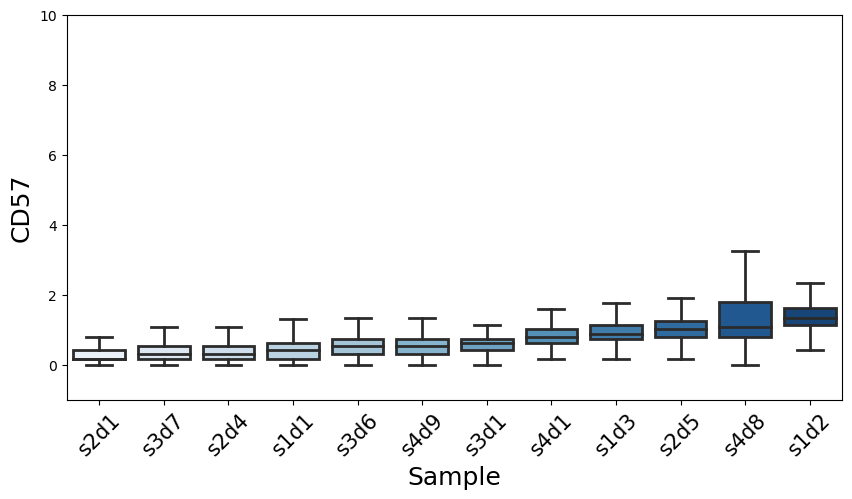

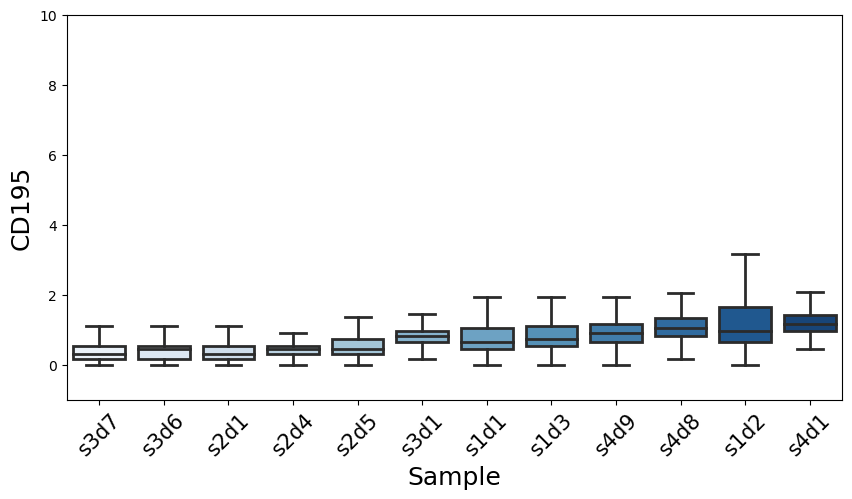

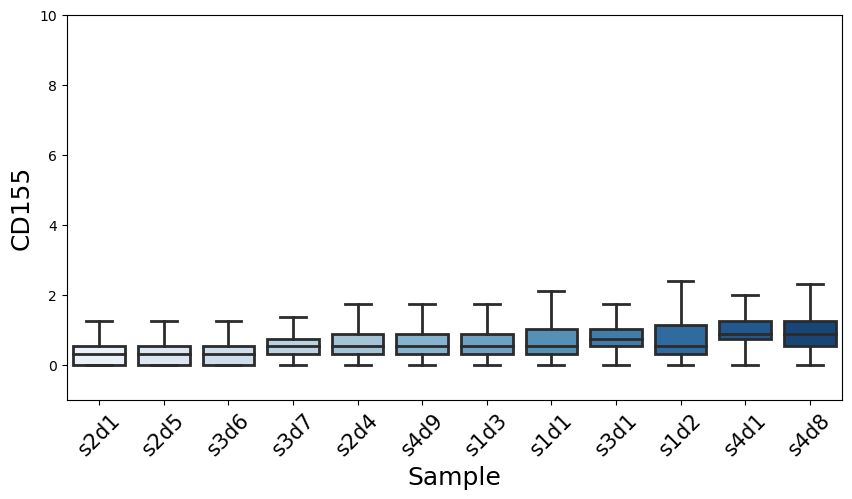

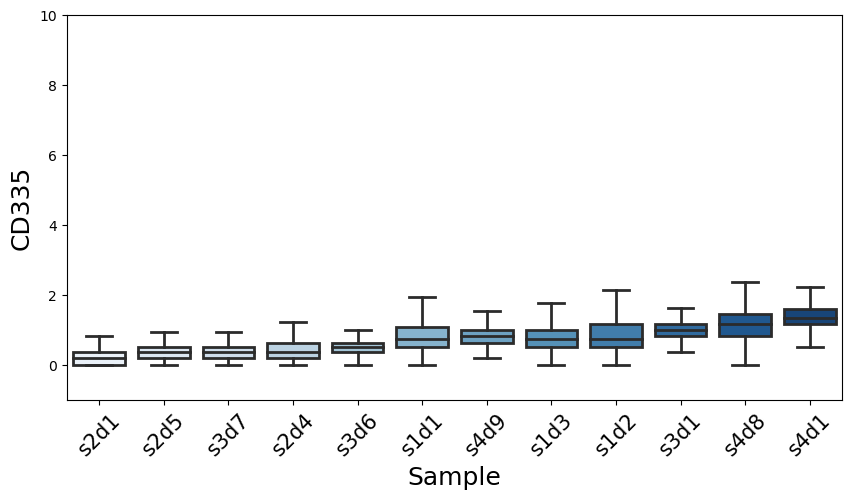

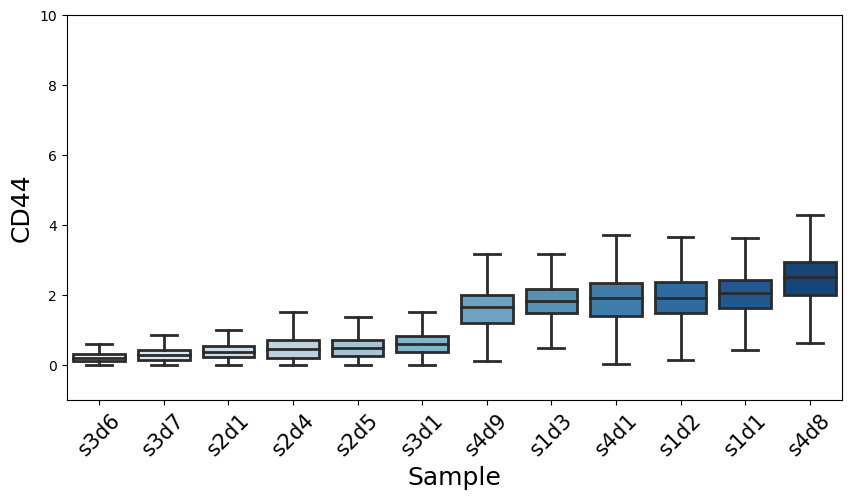

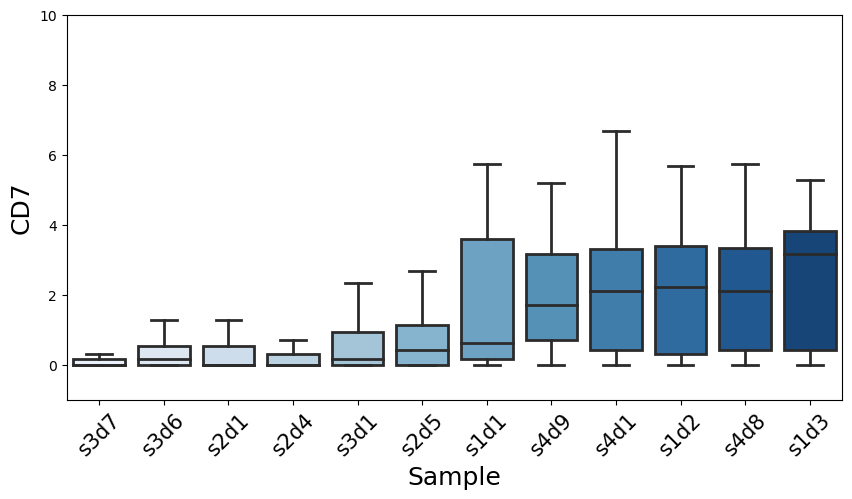

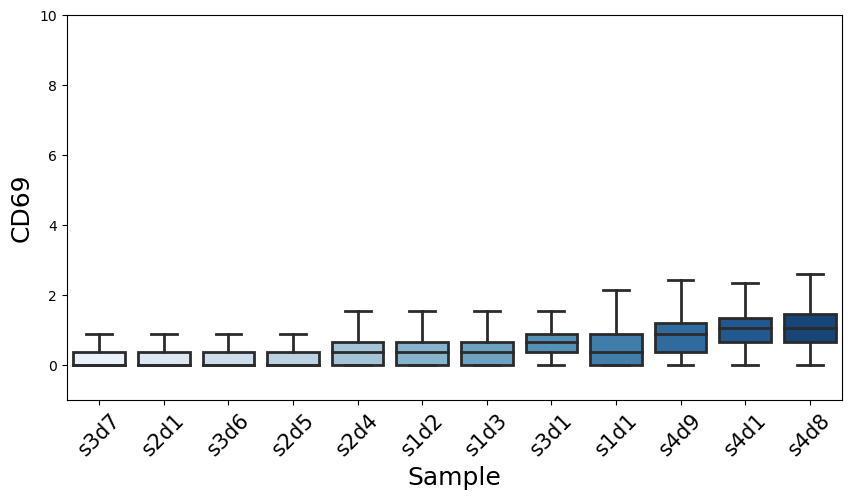

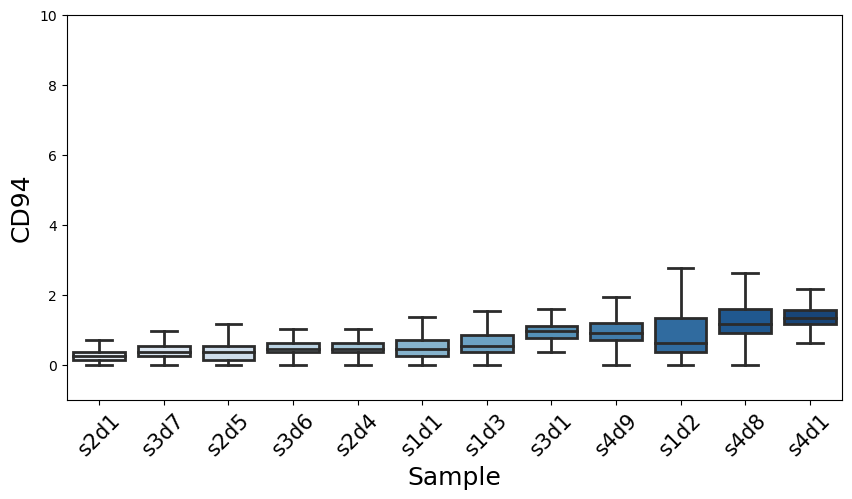

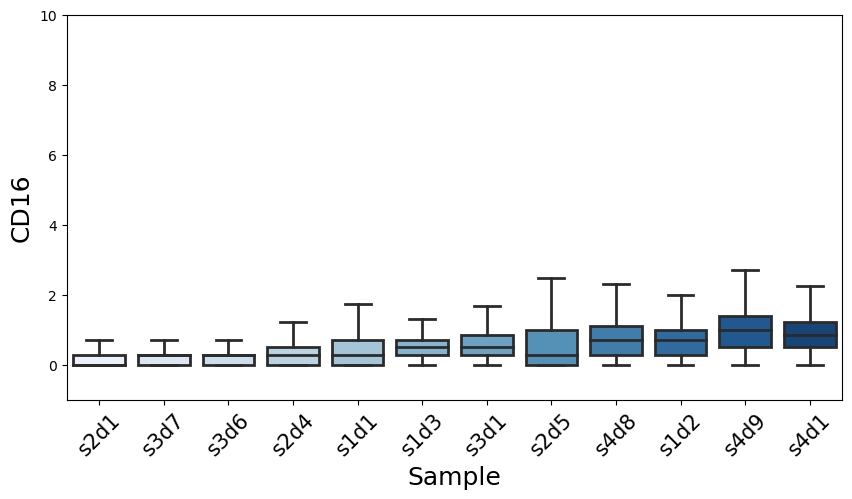

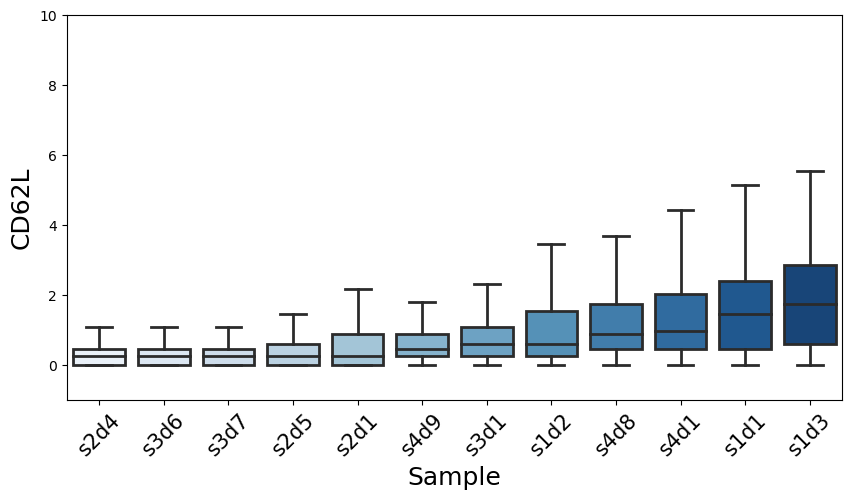

In [32]:
# All markers

for marker in nk_all:
    plt.figure(figsize=[10,5])
    plt.ylim(-1, 10)
    by_counts = df_all.groupby(['Sample'])[marker].mean().sort_values(ascending=True)
    b=sns.boxplot(data=df_all,x="Sample", y=marker, order=by_counts.index, fliersize=0, palette="Blues", linewidth=2)
    b.set_xticklabels(b.get_xticklabels(),rotation=45) 
    b.tick_params(axis='x', labelsize=15)
    plt.xlabel('Sample', fontsize=18)
    plt.ylabel(marker, fontsize=18);

In [33]:

data= df_sorted[['s4d1', 's4d9', 's4d8']].T
data2 = df_sorted[['s3d6', 's3d1', 's3d7']].T
data3 = df_sorted[['s1d2', 's1d1', 's1d3']].T
data4 = df_sorted[['s2d1', 's2d5', 's2d4']].T

In [34]:
data= data[nk_all]
data2 = data2[nk_all]
data3 = data3[nk_all]
data4 = data4[nk_all]

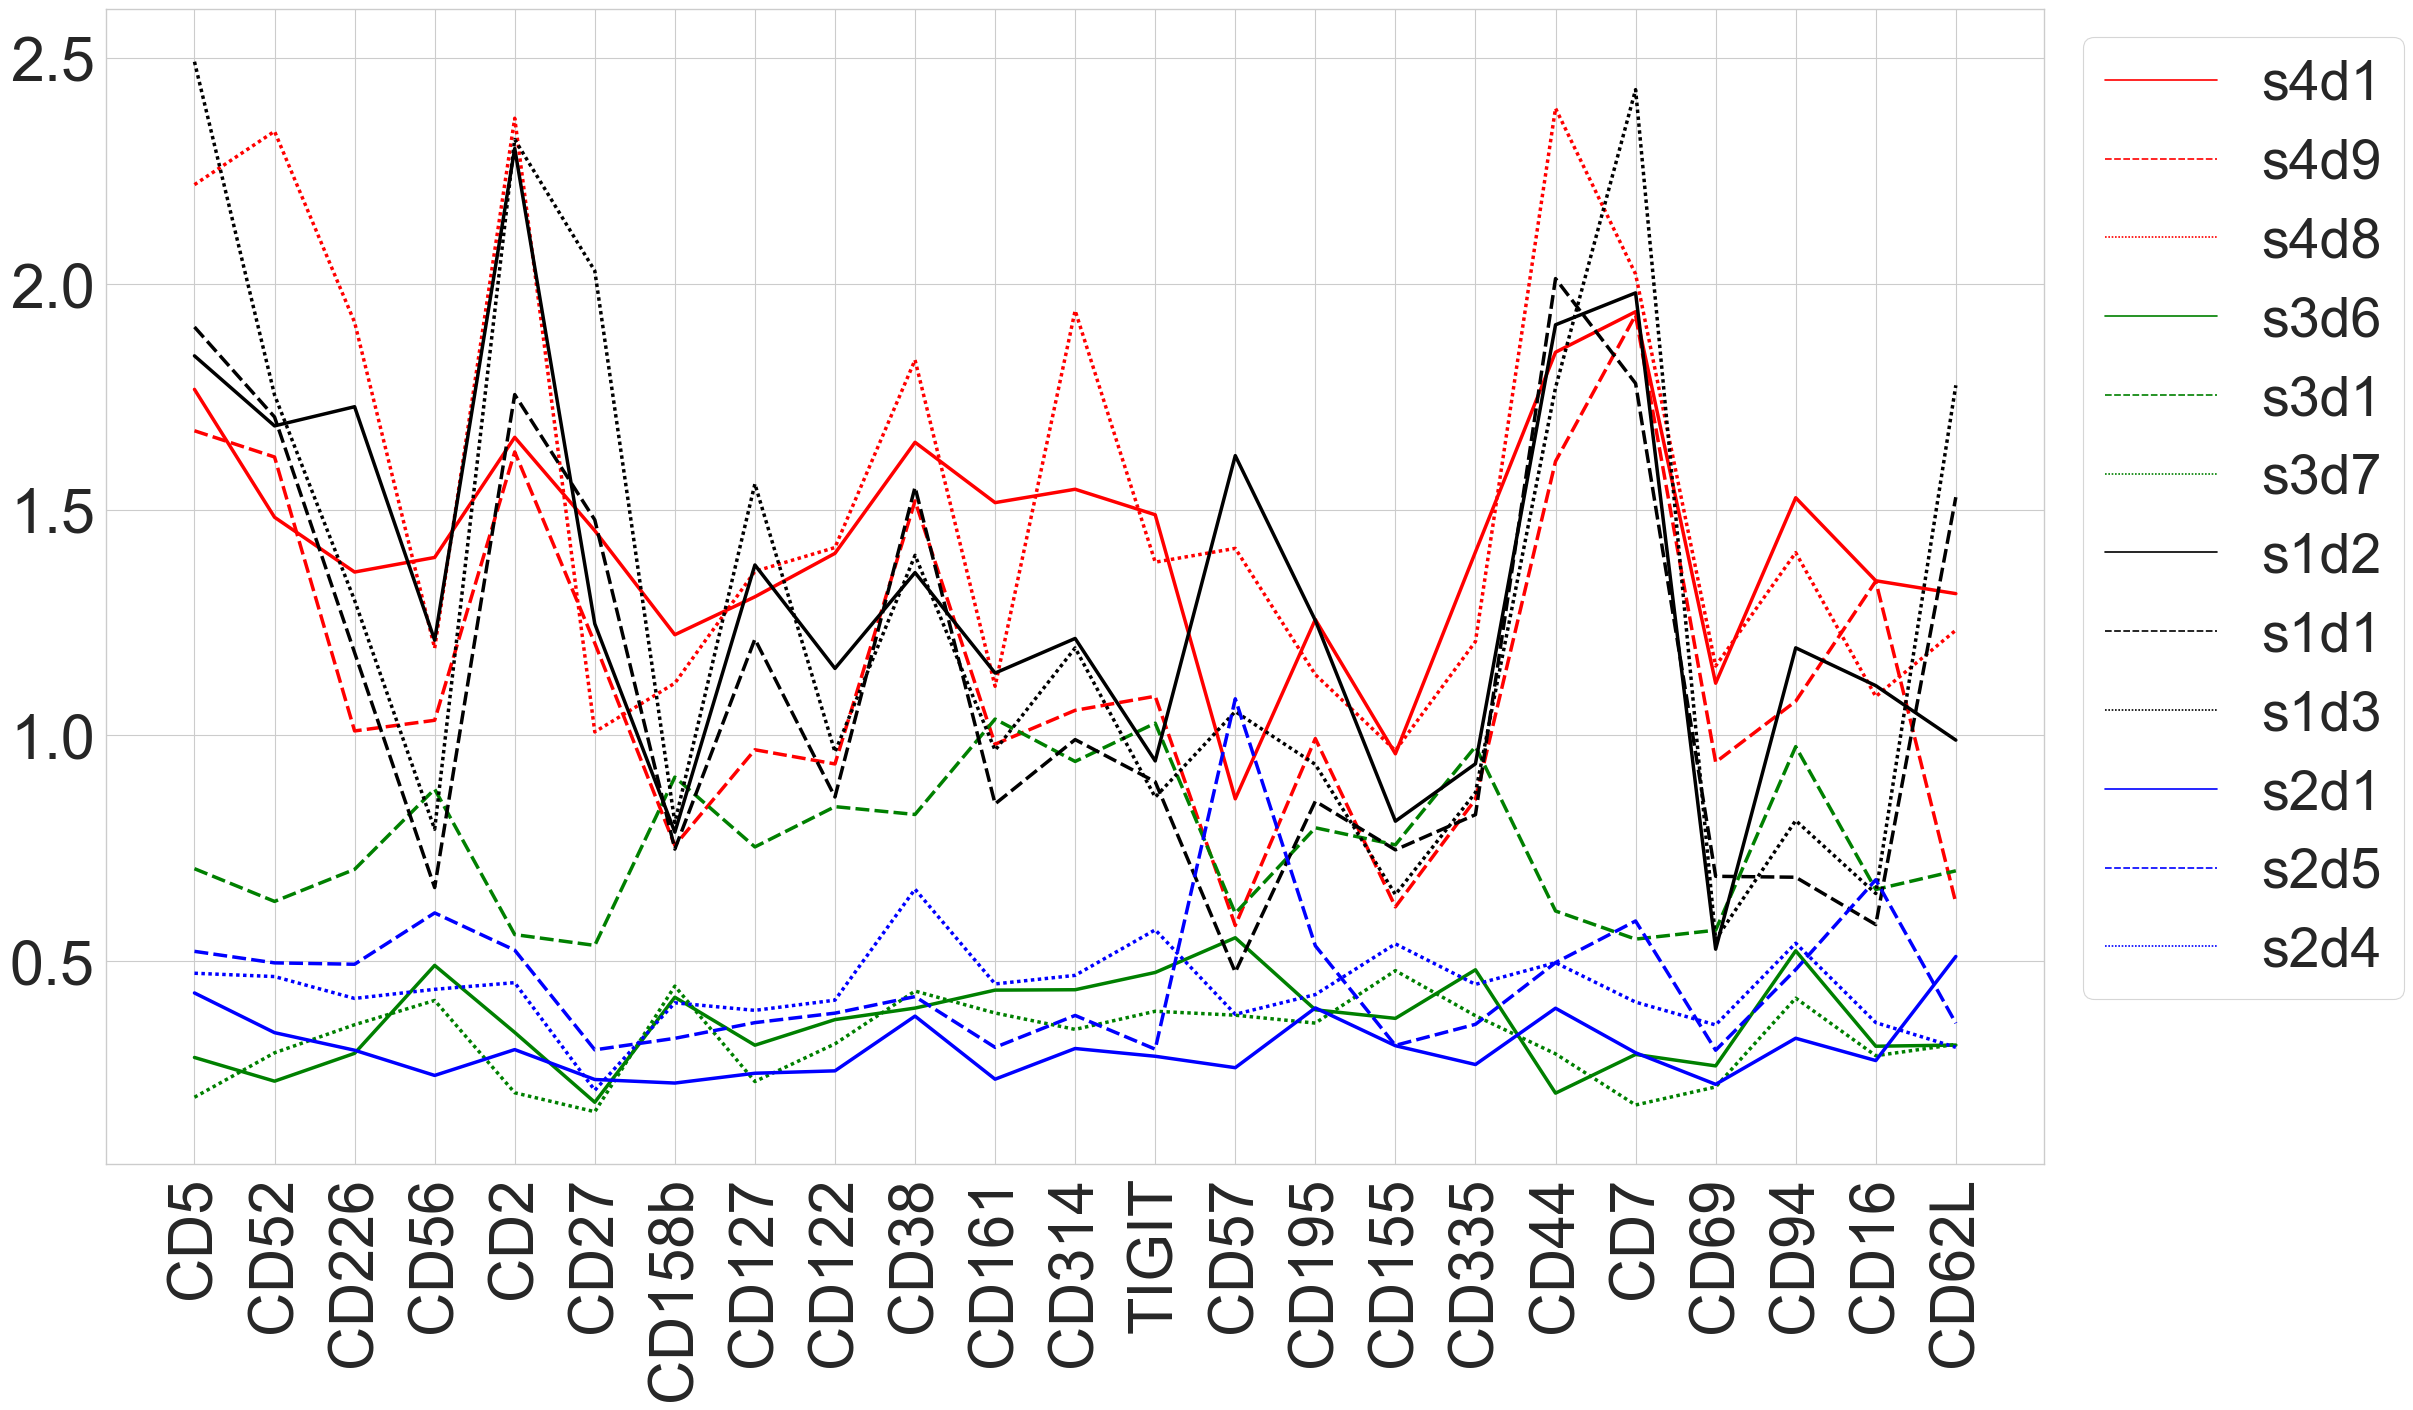

In [59]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=5)  

plt.figure(figsize=[25,15]) ;

sns_plot = sns.lineplot(data=data.T, palette=['red'], linewidth=2.5)
sns_plot = sns.lineplot(data=data2.T, palette=['green'], linewidth=2.5)
sns_plot = sns.lineplot(data=data3.T,palette=['black'],linewidth=2.5)
sns_plot = sns.lineplot(data=data4.T,palette=['blue'],linewidth=2.5)

plt.xticks(rotation=90) 

# Plot formatting
plt.legend(prop={'size': 40}, loc='upper right', bbox_to_anchor=(1.2, 1))


## Number of cells per sample

In [60]:
df_neurips_all= pd.DataFrame(all_cells_neurips)

df_neurips_all=df_neurips_all.T

df_neurips_all.columns=samples

df_neurips_nk= pd.DataFrame(nk_cell_neurips)

df_neurips_nk=df_neurips_nk.T

df_neurips_nk.columns=samples

df_neurips_nk

df_neurips=pd.concat([df_neurips_all, df_neurips_nk])

In [61]:
df_neurips.index = ['All cells', 'NK cells']

df_neurips=df_neurips.T

df_neurips["Sample"]=samples


Text(0.5, 0, ' ')

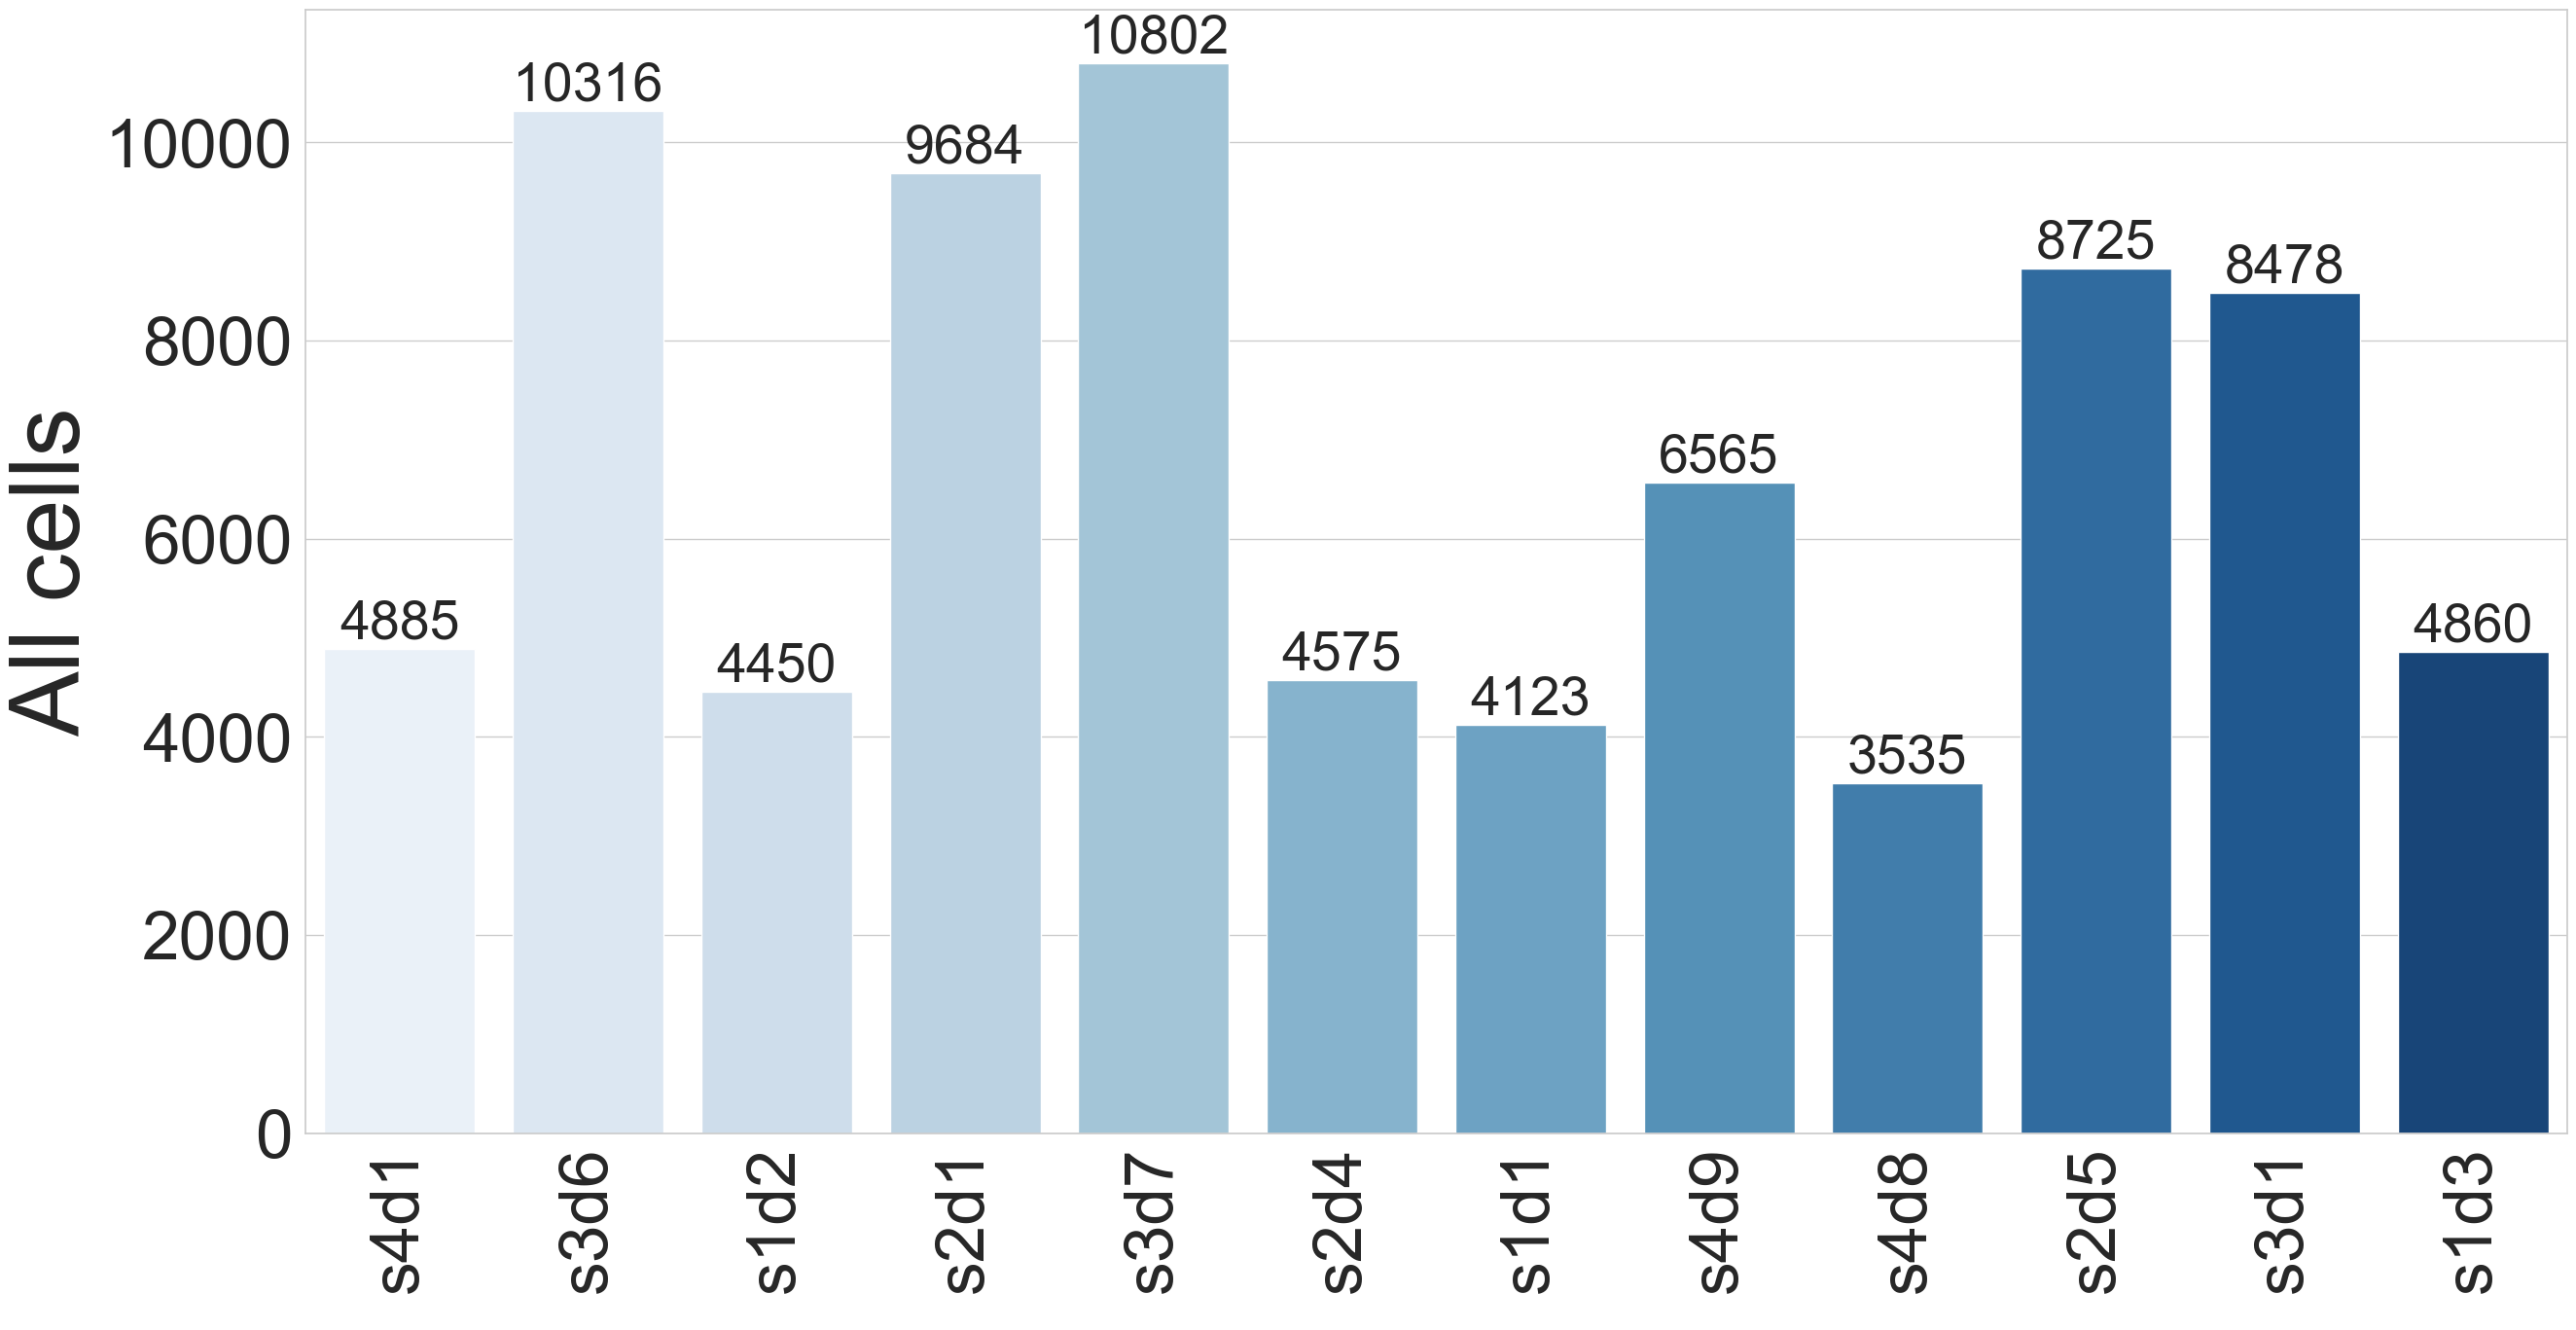

In [73]:
plt.figure(figsize=[30,15])

ax = sns.barplot(data=df_neurips, x="Sample", y="All cells", palette="Blues")
ax.tick_params(axis='x', labelsize=20, rotation=90)
# plt.title("Number of all cells in each sample (Neurips)", fontsize=40) ;
ax.tick_params(axis='y', labelsize=50)
ax.tick_params(axis='x', labelsize=50)
ax.bar_label(ax.containers[0],fontsize=40) ;
plt.xlabel(' ', fontsize=18)



Text(0.5, 0, ' ')

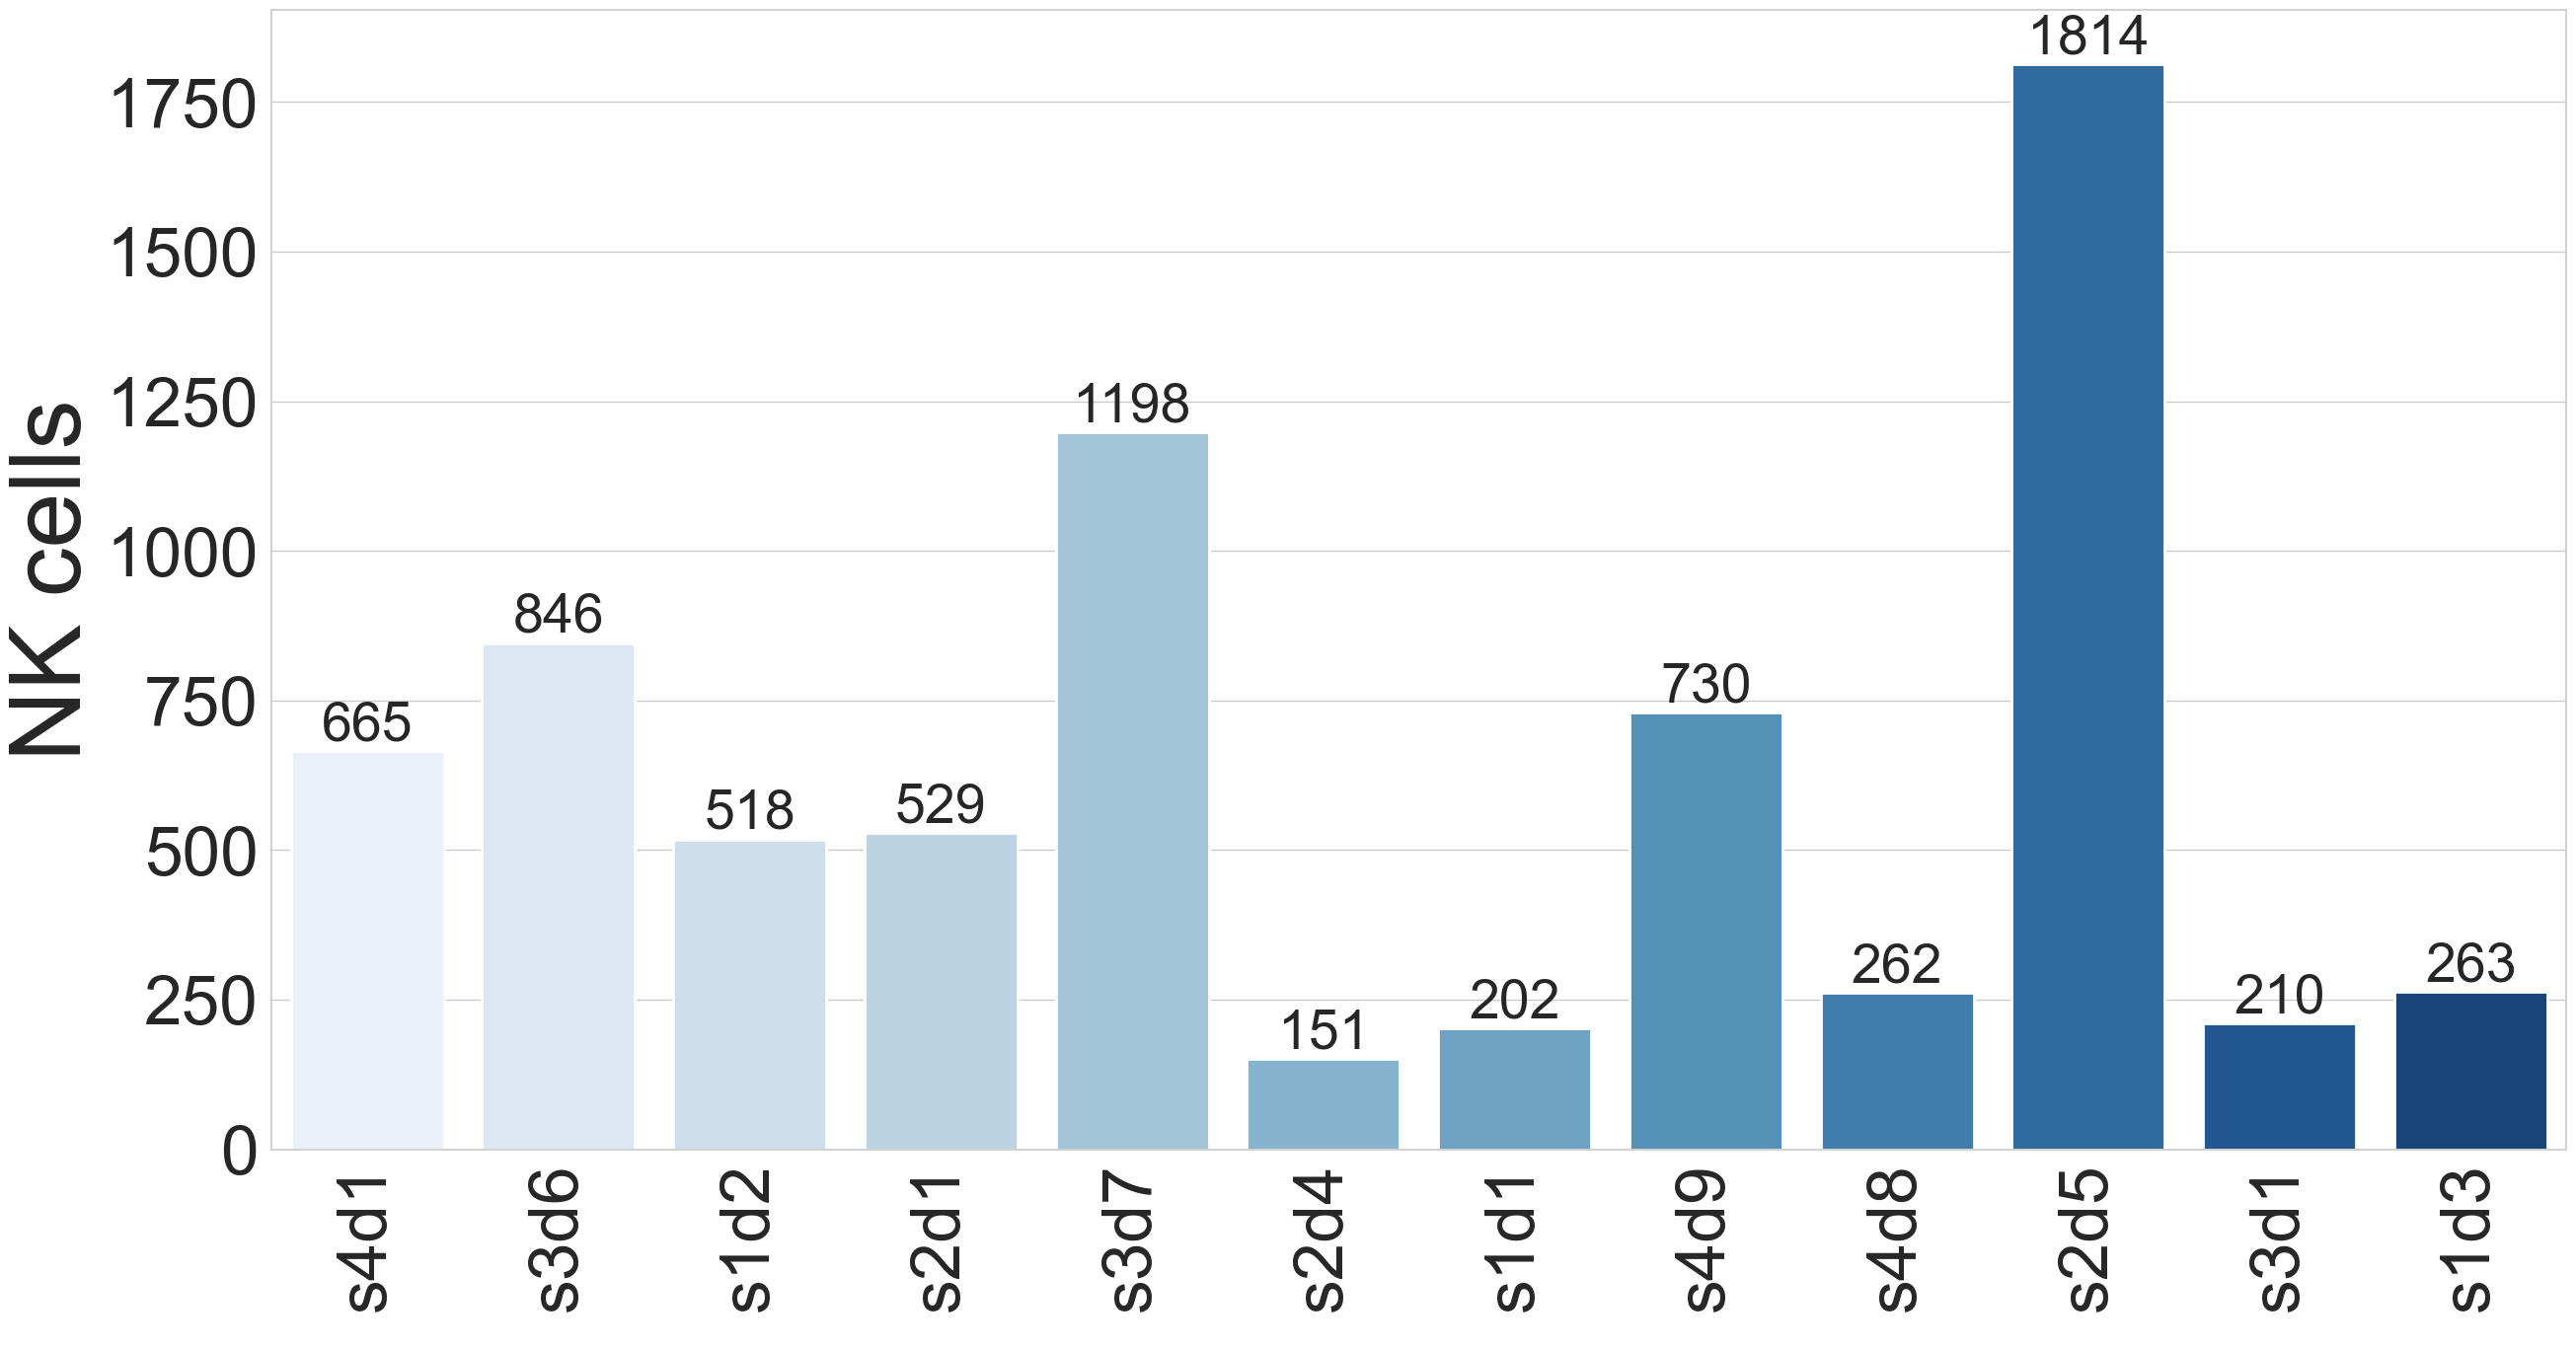

In [75]:
plt.figure(figsize=[30,15])

ax = sns.barplot(data=df_neurips, x="Sample", y="NK cells", palette="Blues")
ax.tick_params(axis='x', labelsize=20, rotation=90)
# plt.title("Number of all cells in each sample (Neurips)", fontsize=40) ;
ax.tick_params(axis='y', labelsize=50)
ax.tick_params(axis='x', labelsize=50)
ax.bar_label(ax.containers[0],fontsize=40) ;
plt.xlabel(' ', fontsize=18)